In [1]:
# Importing the needed libraries:
import numpy as np
from matplotlib import pyplot as plt
import scipy.integrate as integrate
import math
import statistics

# For debug purposes only. To be removed.
import time

In [37]:
# Meixner process parameters. No subordinator.
a = 0.1231
b = -0.5875
d = 3.3588

kappa = 0.5705
eta = 1.5863
lamb = 1.9592
y0 = 1

r = 1.9/100 
q = 1.2/100

S0 = 1124.47

In [3]:
# time_points is the list of points in which we simulate the process at
def BM_path(time_points):
    trajectory = [0]
    for t in range(1, len(time_points)):
        realization = trajectory[-1]+np.sqrt(time_points[t]-time_points[t-1])*np.random.normal()
        trajectory.append(realization)
    return dict(zip(time_points,trajectory))

In [4]:
def poisson_path(intensity, time_points):
    i = intensity*(time_points[1]-time_points[0])
    trajectory = [0]
    for t in time_points:
        trajectory.append(trajectory[-1]+np.random.poisson(i))
    return dict(zip(time_points, trajectory))

In [5]:
# this is defined so that we do not repeatedly compute the integrals inside the meixner trajectory function
def meix_optimization(k, alpha):
    # density function of the meixner measure
    def meixner_meas(x):
        return d*(np.exp(b*x/a)/(x*np.sinh(np.pi*x/a)))
    
    # partitioning via inverse linear boundaries method
    def ilb_partition(k, alpha):
        lhs = [-alpha/i for i in range(1,k+2)]
        rhs = [-x for x in reversed(lhs)]
        return lhs, rhs
        
    # we could experiment with these values
    left_part, right_part = ilb_partition(k,alpha)
    partition = left_part + right_part
    
    # intensities for our Poisson processes
    left_lambdas = [integrate.quad(meixner_meas, left_part[i], left_part[i+1])[0] for i in range(len(left_part)-1)]
    right_lambdas = [integrate.quad(meixner_meas, right_part[i], right_part[i+1])[0] for i in range(len(right_part)-1)]
    lambdas = left_lambdas + right_lambdas
    
    # will be used later on to compute the c's
    x_sqrd = lambda x : x**2*meixner_meas(x) if x!=0 else 0

    # epsilon must be > 0
    def sigma_sqrd(epsilon):
        return integrate.quad(x_sqrd, -epsilon, epsilon)[0]

    # variance of the poisson processes
    c_left = [-np.sqrt(integrate.quad(x_sqrd, left_part[i], left_part[i+1])[0]/left_lambdas[i]) for i in range(len(left_part)-1)]
    c_right = [np.sqrt(integrate.quad(x_sqrd, right_part[i], right_part[i+1])[0]/right_lambdas[i]) for i in range(len(right_part)-1)]
    c = c_left + c_right
    
    # drift
    gamma_ = a*d*np.tan(b/2)-2*d*(integrate.quad(lambda x: np.sinh(b*x/a)/np.sinh(np.pi*x/a), 1, 20)[0])
    
    # used to incorporate the small jumps
    sigma_ = np.sqrt(sigma_sqrd(right_part[0]))
    
    return partition, lambdas, c, gamma_, sigma_

indicator = lambda cond : 1 if cond else 0

In [6]:
partition, lambdas, c, gamma_, sigma_ = meix_optimization(100, 1)

In [8]:
def meixner_trajectory(time_points):
    # the actual trajectory of the meixner process starts here
    bm = BM_path(time_points)
    N = [poisson_path(l, time_points) for l in lambdas]
    
    trajectory = []
    for t in time_points:
        s = [c[j]*( N[j][t] - lambdas[j]*t*indicator(np.abs(c[j]) < 1) ) for j in range(len(c))]
        #s = [c[j]*( N[j][t] - lambdas[j]*t) for j in range(200)]
        realization = gamma_*t + sigma_*bm[t] + sum(s)
        #realization = sigma_*bm[t] + sum(s)
        trajectory.append(realization)
    return dict(zip(time_points,trajectory))

In [9]:
def cir(T, time_points):
    increment = T/time_points
    y = np.zeros(time_points)
    y[0] = y0
    for i in range(time_points-1):
        y[i+1] = np.abs(y[i] + kappa * (eta - y[i]) * increment + lamb * math.sqrt(y[i])*math.sqrt(increment) * np.random.normal(0,1))
    return y

In [13]:
def int_cir(T, time_points):
    Y = np.zeros(time_points+1)
    Y[0] = y0
    fixed_cir = cir(T, time_points)
    for i in range(len(cir(T, time_points))):
        Y[i+1] = Y[i] + fixed_cir[i]
    return dict(zip([T/time_points * i for i in range(time_points+1)], Y/time_points))

In [15]:
def subordinated_meixner(T, time_points):
    path = int_cir(T, time_points)
    det_time = list(path.keys())
    t_points = list(path.values())
    sub_meix = list(meixner_trajectory(t_points).values())
    return dict(zip(det_time, sub_meix))

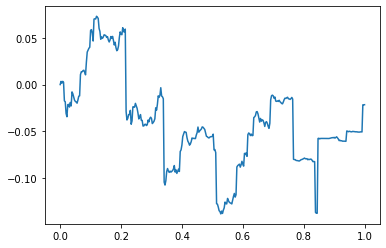

In [19]:
s = subordinated_meixner(1, 360)
plt.plot(list(s.keys()), list(s.values()))

In [39]:
def sub_e(t):
    coth = lambda x : np.cosh(x)/np.sinh(x) if x != 0 else 0
    def phi_cir(t, u):
        gamma = np.sqrt(complex(kappa**2, -2*lamb**2*u))
        return np.exp(kappa**2*eta*t/(lamb**2))*np.exp(complex(0,2*y0*u)/(kappa + gamma*coth(gamma*t/2)))/((np.cosh(gamma*t/2) + kappa/gamma*np.sinh(gamma*t/2))**(2*kappa*eta/lamb**2))

    def psi_X(t, u):
        return np.log((np.cos(b/2)/np.cosh(complex(a*u,-b)/2))**(2*d))

    def phi(t, u):
        return np.exp(complex(0, u*((r-q)*t)))*(phi_cir(t, complex(0,-psi_X(t, u))))/(phi_cir(t, complex(0,-psi_X(t, complex(0,-1)))))**complex(0,u)

    exp_value = phi(t, complex(0,-1))
    return np.real(exp_value)

In [41]:
sub_e(337/365)

1.0064839440383928

In [43]:
def meixner_sub_martingale(T, time_points):
    path = subordinated_meixner(T, time_points)
    t = np.array(list(path.keys()))
    x_yt = np.array(list(path.values()))
    risk_neutral = S0*np.exp((r-q)*t)/sub_e(T) * np.exp(x_yt)
    return dict(zip(t, list(risk_neutral)))

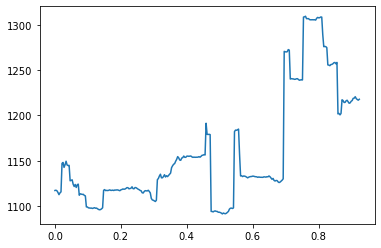

In [44]:
sub_path = meixner_sub_martingale(337/365, 300) 
plt.plot(sub_path.keys(), sub_path.values())

# Monte Carlo simulations with Subordinator

In [45]:
def payoff_eur_call(ST, K):
    return max(ST-K,0)

In [48]:
def mc_ec_sub_meixner(T, K, sims):
    t=[]
    for i in range(sims):
        final_value = list(meixner_sub_martingale(T,250).values())[-1]
        t.append(payoff_eur_call(final_value, K))
    return np.exp(-r*T)*np.mean(t)

In [50]:
%%time
resl = mc_ec_sub_meixner(337/365, 1150, 1000)

CPU times: user 3min 15s, sys: 379 ms, total: 3min 15s
Wall time: 3min 15s


In [51]:
resl

21.541164447911562